In [1]:
import os
import random 
import numpy as np
import pickle
from subprocess import call
from shutil import copyfile
from scipy.io import wavfile
import scipy.misc
import librosa
import time
from IPython.core.display import HTML
import argparse
import os
import logging

import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets

%matplotlib inline
import matplotlib.pyplot as plt
%pylab inline
from matplotlib import cm

from model import birds_eval

/home/austin/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.
Populating the interactive namespace from numpy and matplotlib


/home/austin/tensorflow/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
# Define some helper functions before we begin.

In [2]:
def list_images(directory):
    """
    Get all the images and labels in directory/label/*.jpg
    """
    labels = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]
    # Sort the labels so that training and validation get them in the same order
    labels.sort()

    files_and_labels = []
    for label in labels:
        for f in os.listdir(os.path.join(directory, label)):
            files_and_labels.append((os.path.join(directory, label, f), label))

    filenames, labels = zip(*files_and_labels)
    filenames = list(filenames)
    labels = list(labels)
    unique_labels = sorted(list(set(labels)), key=int)

    labels = [int(l) for l in labels]

    return filenames, labels


# def list_images(directory):
#     """
#     Get all the images and labels in directory/label/*.jpg
#     """
#     labels = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]
#     # Sort the labels so that training and validation get them in the same order
#     labels.sort()

#     files_and_labels = []
#     for label in labels:
#         for f in os.listdir(os.path.join(directory, label)):
#             files_and_labels.append((os.path.join(directory, label, f), label))

#     filenames, labels = zip(*files_and_labels)
#     filenames = list(filenames)
#     labels = list(labels)
#     unique_labels = sorted(list(set(labels)), key=int)

#     label_to_int = {}
#     for i, label in enumerate(unique_labels, 1):
#         label_to_int[label] = i

#     labels = [label_to_int[l] for l in labels]

#     return filenames, labels


def list_images_split(directory, num_split=2):
    """
    Get all the images and labels in directory/label/*.jpg
    """
    labels = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]
    # Sort the labels so that training and validation get them in the same order
    labels.sort()
    train_files_and_labels = []
    val_files_and_labels = []
    
    balance_factors_path = os.path.join(directory, 'balance_factors.txt')
    if os.path.isfile(balance_factors_path):
        print("Balancing training data using balance_factors.txt")
        balance_factors = read_counts_file(balance_factors_path)
        for label in labels:
            for count, f in enumerate(reversed(os.listdir(os.path.join(directory, label)))):
                if count < num_split:
                    val_files_and_labels.append((os.path.join(directory, label, f), label))
                else:
                    for i in range(balance_factors[label]):
                        train_files_and_labels.append((os.path.join(directory, label, f), label))
    else:
        for label in labels:
            for count, f in enumerate(reversed(os.listdir(os.path.join(directory, label)))):
                if count < num_split:
                    val_files_and_labels.append((os.path.join(directory, label, f), label))
                else:
                    train_files_and_labels.append((os.path.join(directory, label, f), label))

    train_filenames, train_labels = zip(*train_files_and_labels)
    train_filenames = list(train_filenames)
    train_labels = list(train_labels)
    unique_labels = sorted(list(set(train_labels)), key=int)
    label_to_int = {}
    for i, label in enumerate(unique_labels, 1):
        label_to_int[label] = i
    train_labels = [label_to_int[l] for l in train_labels]
    
    val_filenames, val_labels = zip(*val_files_and_labels)
    val_filenames = list(val_filenames)
    val_labels = list(val_labels)
    unique_labels = sorted(list(set(val_labels)), key=int)
    label_to_int = {}
    for i, label in enumerate(unique_labels, 1):
        label_to_int[label] = i
    val_labels = [label_to_int[l] for l in val_labels]

    return train_filenames, train_labels, val_filenames, val_labels
         

def read_label_file(path):
    """Reads the labels file and returns a mapping from ID to class name.

    Args:
    dataset_dir: The directory in which the labels file is found.
    filename: The filename where the class names are written.

    Returns:
    A map from a label (integer) to class name.
    """
    labels_filename = path
    with tf.gfile.Open(labels_filename, 'rb') as f:
        lines = f.read().decode()
    lines = lines.split('\n')
    lines = filter(None, lines)

    labels_to_class_names = {}
    for line in lines:
        index = line.index(':')
        labels_to_class_names[int(line[:index])] = line[index+1:]
    return labels_to_class_names


def probs_to_ranks(array):
    # Return ranks for each entry in an array - e.g. the highest scoring element would receive rank 1, etc.
    output = [0] * len(array)
    for i, x in enumerate(sorted(range(len(array)), key=lambda y: array[y], reverse=True)):
        output[x] = i + 1
    return output

# Display some sample images and associated labels.

In [3]:
def list_samples(directory, num_classes=48):
    """
    Get all the images and labels in directory/label/samples/* (.jpg or .wav)
    """
    labels = os.listdir(directory)
    # Sort the labels so that training and validation get them in the same order
    labels.sort()

    files_and_labels = []
    for label in labels:
        if int(label) > num_classes:
            continue
        for f in os.listdir(os.path.join(directory, label, 'samples')):
            if f.lower().endswith('.jpg'):
                name = os.path.splitext(f)[0]
                img_name = name + '.jpg'
                wav_name = name + '.wav'
                files_and_labels.append((os.path.join(directory, label, 'samples', img_name), 
                                         os.path.join(directory, label, 'samples', wav_name), 
                                         label))

    img_filenames, wav_filenames, labels = zip(*files_and_labels)
    img_filenames = list(img_filenames)
    wav_filenames = list(wav_filenames)
    labels = list(labels)
    unique_labels = list(set(labels))

    label_to_int = {}
    for i, label in enumerate(unique_labels):
        label_to_int[label] = i

    labels = [label_to_int[l] for l in labels]

    return img_filenames, wav_filenames, labels, files_and_labels


def random_sample(files_and_labels, label):
    label = str(label)
    num_samples = len(files_and_labels)
    count = 0
    
    while count < num_samples:
        img_sample, wav_sample, label_sample = files_and_labels[np.random.choice(len(files_and_labels))]
        if label_sample == label:
            return img_sample, wav_sample
        count += 1
        

def write_samples_file(path, true_sample, predicted_sample):
    with open(path, 'w') as f:
        f.write('%s %s\n' % ('True Class:', true_sample))
        f.write('%s %s\n' % ('Prediction:', predicted_sample))
        
        
def img_parse_function(filename):
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    #image = tf.cast(image_decoded, tf.float32)
    image = tf.image.convert_image_dtype(image_decoded, dtype=tf.float32)
    image.set_shape([224, 341, 3])

    # Want a 3.5 second slice of 4.0 second spectrogram to be square (299x299) - set new_width accordingly
    new_height = tf.to_int32(299.0)
    new_width = tf.to_int32(319.0)     ## 341.0 
    crop_height = tf.to_int32(299.0)
    crop_width = tf.to_int32(299.0)

    image = tf.image.resize_images(image, [new_height, new_width])  # (2)

    max_offset_height = tf.reshape(new_height - crop_height + 1, [])
    max_offset_width = tf.reshape(new_width - crop_width + 1, [])
    offset_height = tf.constant(0, dtype=tf.int32)
    offset_width = tf.random_uniform([], maxval=max_offset_width, dtype=tf.int32)

    original_shape = tf.shape(image)
    cropped_shape = tf.stack([crop_height, crop_width, original_shape[2]])

    offsets = tf.to_int32(tf.stack([offset_height, offset_width, 0]))
    image = tf.slice(image, offsets, cropped_shape)
    image.set_shape([299, 299, 3])
    #image = tf.reshape(image, cropped_shape)

    image = tf.subtract(image, 0.5)
    image = tf.multiply(image, 2.0)
    
    image_raw = tf.expand_dims(image, 0)
    image_raw = tf.image.resize_images(image_raw, [crop_height, crop_width])
    image_raw = tf.squeeze(image_raw)

    return image, image_raw

In [4]:
def evaluate_examples_with_samples(args, num_examples=1, target_dir='examples', start_idx=0):
    """Evaluates test images on a trained Inception-v3 network and displays samples for visualization.
    
    `num_examples` test images are taken from args['data_dir']/test and evaluated using the
    latest checkpoint in args['eval_dir']. For each example, the labeled and processed spectrogram,
    plus random samples from the true and predicted classes taken from args['snip_dir'], are
    saved to `target_dir`.
    
    Parameters
    ----------
    args : dict
        Arguments used to setup of Inception-v3 model - see `eval.py`
    num_examples : int
        Number of examples to evaluate.
    target_dir: str
        Target directory for image samples.
    start_idx: int
        Starting integer label for image samples.
    """

    test_dir = os.path.join(args['data_dir'], 'test')
    restore_dir = args['eval_dir']
    labels_path = os.path.join(args['data_dir'], 'labels.txt')
    
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    
    logging.info('Loading dataset from `test_dir`...')
    test_filenames, test_labels = list_images(test_dir)
    num_test = len(test_filenames)
    logging.info("%d test images over %d classes found." %
                 (num_test, len(set(test_labels))))
    num_classes = 49
    top_k = 5
    batch_norm_params = {'decay': 0.9997, 'epsilon': 0.001}    

    logging.info("Building graph...")
    g2 = tf.Graph()
    with g2.as_default():
        def _parse_function(filename, label):
            image_string = tf.read_file(filename)
            image_decoded = tf.image.decode_jpeg(image_string, channels=3)
            image = tf.image.convert_image_dtype(image_decoded, dtype=tf.float32)
            image.set_shape([224, 341, 3])

            new_height = tf.to_int32(299.0)
            new_width = tf.to_int32(319.0)   # use 341.0 instead for 3.5 s slice
            crop_height = tf.to_int32(299.0)
            crop_width = tf.to_int32(299.0)
            image = tf.image.resize_images(image, [new_height, new_width])

            max_offset_height = tf.reshape(new_height - crop_height + 1, [])
            max_offset_width = tf.reshape(new_width - crop_width + 1, [])
            offset_height = tf.constant(0, dtype=tf.int32)
            offset_width = tf.random_uniform([], maxval=max_offset_width, dtype=tf.int32)
            original_shape = tf.shape(image)
            cropped_shape = tf.stack([crop_height, crop_width, original_shape[2]])
            offsets = tf.to_int32(tf.stack([offset_height, offset_width, 0]))
            image = tf.slice(image, offsets, cropped_shape)
            image.set_shape([299, 299, 3])

            image = tf.subtract(image, 0.5)
            image = tf.multiply(image, 2.0)
            return image, label

        # Load test data from `test_filenames` then batch the data.
        val_dataset = tf.data.Dataset.from_tensor_slices((test_filenames,
                                                          test_labels))
        val_dataset = val_dataset.map(_parse_function,
                                      num_parallel_calls=args['num_workers'])
        batched_val_dataset = val_dataset.batch(args['batch_size'])
        iterator = tf.data.Iterator.from_structure(
            batched_val_dataset.output_types,
            batched_val_dataset.output_shapes)
        images, labels = iterator.get_next()
        
        img_sample = tf.placeholder(tf.string)
        img_sample_parsed = img_parse_function(img_sample)[1]
        
        val_init_op = iterator.make_initializer(batched_val_dataset)
        is_training = tf.placeholder(tf.bool)

        # Load the Inception-v3 model from the Slim library.
        inception = tf.contrib.slim.nets.inception
        with slim.arg_scope(inception.inception_v3_arg_scope(
                            weight_decay=args['weight_decay'],
                            batch_norm_decay=batch_norm_params['decay'],
                            batch_norm_epsilon=batch_norm_params['epsilon'])):
            logits, end_points = inception.inception_v3(images,
                num_classes=num_classes,
                is_training=is_training,
                dropout_keep_prob=args['dropout_keep_prob'])

        # Restore all weights variables in the model.
        # Calling function `restore_fn(sess)` will load the pretrained weights
        # from the checkpoint file at `restore_dir`.
        all_variables = tf.contrib.framework.get_variables_to_restore()
        restore_fn = tf.contrib.framework.assign_from_checkpoint_fn(
            tf.train.latest_checkpoint(restore_dir), all_variables)

        tf.losses.sparse_softmax_cross_entropy(labels=labels,
                                               logits=logits,
                                               weights=1.0)
        tf.losses.sparse_softmax_cross_entropy(labels=labels,
                                               logits=end_points['AuxLogits'],
                                               weights=0.4)
        loss = tf.losses.get_total_loss()

        # Compute some evaluation metrics.
        kw_predictions = tf.argmax(end_points['Predictions'], 1)
        kw_probabilities = end_points['Predictions']
        prediction = tf.to_int32(tf.argmax(logits, 1))
        correct_prediction = tf.equal(prediction, labels)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        top5_accuracy = tf.reduce_mean(tf.cast(
            tf.nn.in_top_k(end_points['Logits'], labels, top_k), tf.float32))

        # Merge all summary nodes and create an init op.
        init = tf.global_variables_initializer()
        tf.get_default_graph().finalize()

    labels_to_names = birds_eval.read_label_file(labels_path)

    with tf.Session(graph=g2) as sess:
        sess.run(init)
        logging.info('Restoring from latest checkpoint in %s.', args['eval_dir'])
        restore_fn(sess)
        
        # Run through all test data once.
        logging.info('Starting evaluation on test images...')
        sess.run(val_init_op)
        
        sample_idx = start_idx
        # Run as many batches as we need to evaluate the desired number (`num_examples`) of test images.
        for i in range(int((num_examples - 1) // args['batch_size']) + 1):
            try:
                np_probabilities, np_images, np_labels = sess.run([kw_probabilities, images, labels], 
                                                                  {is_training: False})
            except tf.errors.OutOfRangeError:
                logging.info('OutOfRangeError encountered. Terminating evaluation...')
                break
            for j in range(args['batch_size']):
                solo_path = os.path.join(target_dir, 'sample_%d.png' % sample_idx)
                duo_path = os.path.join(target_dir, 'duo_%d.png' % sample_idx)
                samples_path = os.path.join(target_dir, 'samples_%d.txt' % sample_idx)
                
                image = np_images[j, :, :, :]
                true_label = np_labels[j]
                probs = np_probabilities[j, :]
                true_rank = probs_to_ranks(probs)[true_label]
                predicted_label = np.argmax(probs)
                predicted_name = labels_to_names[predicted_label]
                true_name = labels_to_names[true_label]

                image = ((image + 1.0)/2.0 * 255).round().astype(uint8)

                f = plt.figure(figsize=(7,7))
                plt.imshow(image[:,:,0], cmap='bone')
                plt.title('True Class: [%s - %s] (ranked %d of 48) \nModel Prediction: [%s - %s]' % 
                          (true_label, true_name, true_rank, predicted_label, predicted_name))
                plt.axis('off')
                plt.show()
                f.savefig(solo_path, bbox_inches='tight')

                label1 = true_label
                label2 = predicted_label
                name1 = labels_to_names[label1]
                name2 = labels_to_names[label2]
                _, _, _, files_and_labels = list_samples(args['snip_dir'])

                try:
                    img_sample1, wav_sample1 = random_sample(files_and_labels, label1)
                    img_sample2, wav_sample2 = random_sample(files_and_labels, label2)
                except TypeError:
                    print("No sample with given label.")
                    return

                image_raw1 = sess.run(img_sample_parsed, {img_sample: img_sample1})
                image_raw2 = sess.run(img_sample_parsed, {img_sample: img_sample2})

                img1 = image_raw1[:, :]
                img1 = ((img1 + 1.0)/2.0 * 255).round().astype(uint8)
                img2 = image_raw2[:, :]
                img2 = ((img2 + 1.0)/2.0 * 255).round().astype(uint8)

                f, axarr = plt.subplots(1, 2, figsize=(15,15))
                axarr[0].imshow(img1[:,:,0], cmap='bone')
                axarr[1].imshow(img2[:,:,0], cmap='bone')
                axarr[0].set_title('Random Sample of True Class [#%s - %s]' % (str(label1), name1))
                axarr[0].axis('off')
                axarr[1].set_title('Random Sample of Predicted Class [#%s - %s]' % (str(label2), name2))
                axarr[1].axis('off')
                plt.show()
                f.savefig(duo_path, bbox_inches='tight')

                print(wav_sample1)
                display(HTML('<a href="%s">WAV sample of class [#%s - %s]</a>' % 
                             (wav_sample1, str(label1), name1)))
                print(wav_sample2)
                display(HTML('<a href="%s">WAV sample of class [#%s - %s]</a>' % 
                             (wav_sample2, str(label2), name2)))
                write_samples_file(samples_path, wav_sample1, wav_sample2)                

                sample_idx += 1




### Display some examples using the functions above.

In [7]:
args = {}
args['data_dir'] = 'demo/data_demo'
args['eval_dir'] = '/home/austin/projects/bob/learn/runs/1102/save'
args['snip_dir'] = '/home/austin/projects/bob/snips'
args['batch_size'] = 2
args['num_workers'] = 4
args['dropout_keep_prob'] = 0.8
args['weight_decay'] = 0.00004

INFO:tensorflow:Restoring parameters from /home/austin/projects/bob/learn/runs/1102/save/full-240


INFO:tensorflow:Restoring parameters from /home/austin/projects/bob/learn/runs/1102/save/full-240


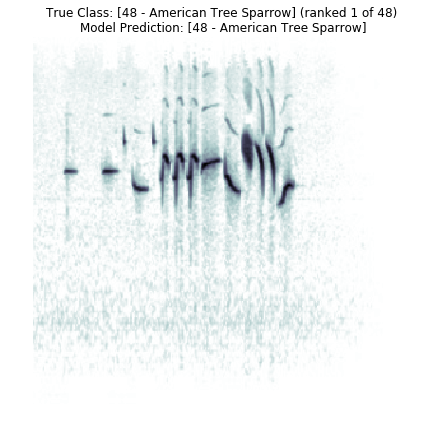

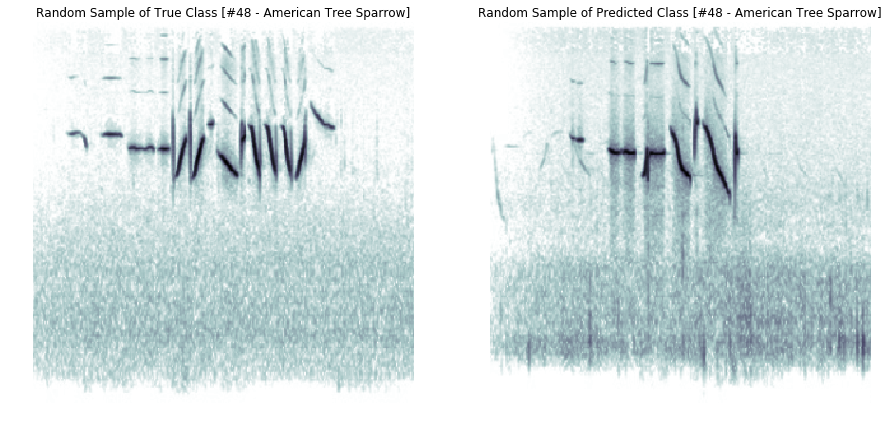

/home/austin/projects/bob/snips/48/samples/0.wav


/home/austin/projects/bob/snips/48/samples/2.wav


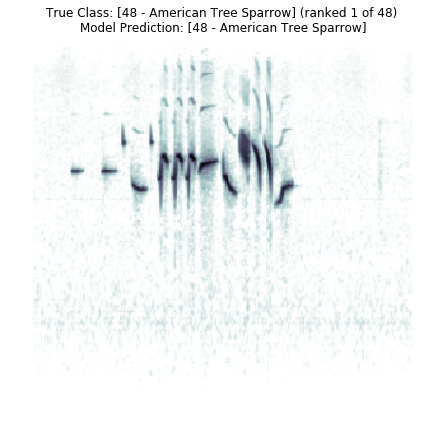

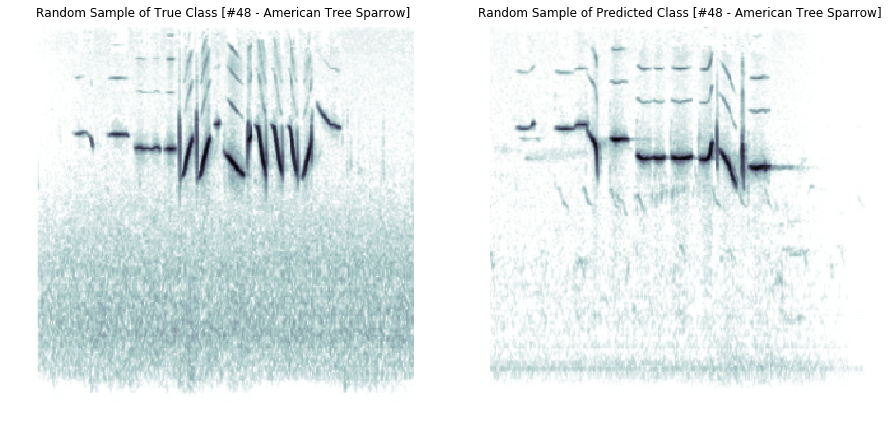

/home/austin/projects/bob/snips/48/samples/0.wav


/home/austin/projects/bob/snips/48/samples/4.wav


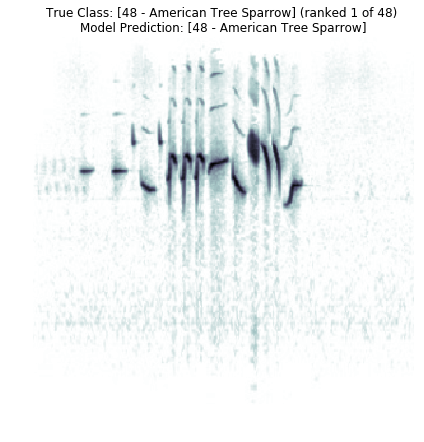

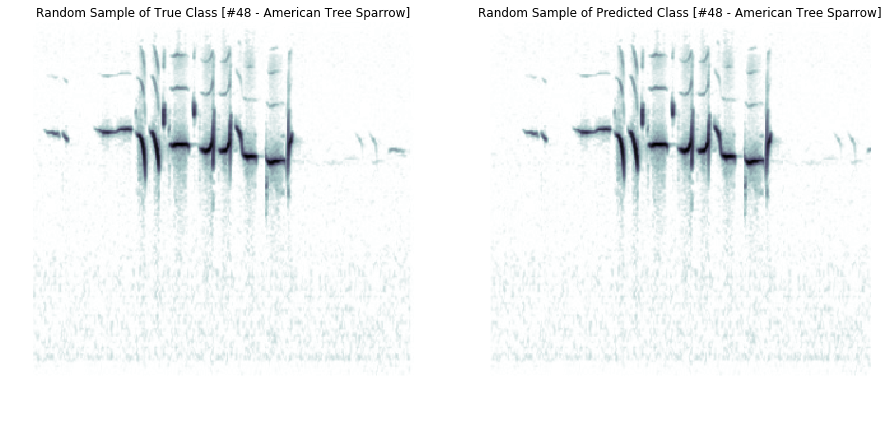

/home/austin/projects/bob/snips/48/samples/1.wav


/home/austin/projects/bob/snips/48/samples/1.wav


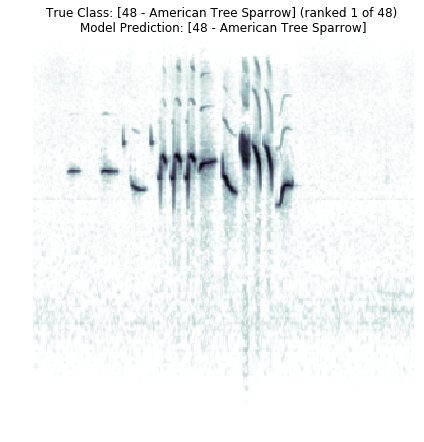

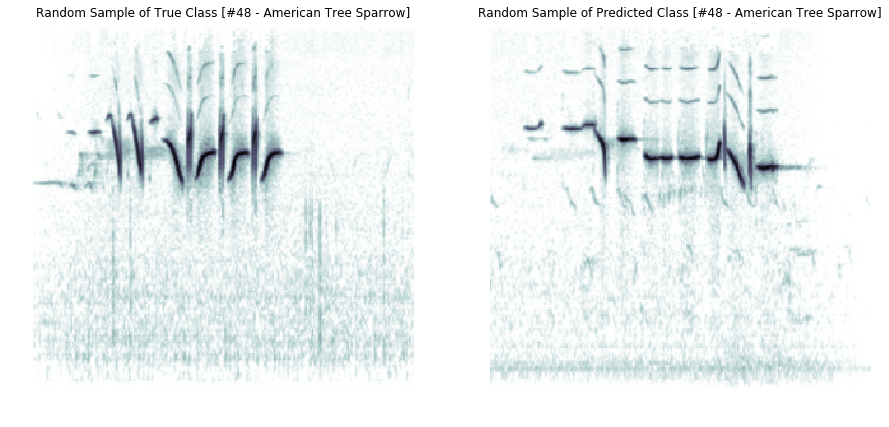

/home/austin/projects/bob/snips/48/samples/3.wav


/home/austin/projects/bob/snips/48/samples/4.wav


In [8]:
evaluate_examples_with_samples(args, num_examples=4, target_dir='samples', start_idx=0)

## Testing below...

In [ ]:
def write_samples_file(path, true_sample, predicted_sample):
    with open(path, 'w') as f:
        f.write('%s %s\n' % ('True Class:', true_sample))
        f.write('%s %s\n' % ('Prediction:', predicted_sample))
        

def display_examples_with_samples(args):
    # Define the graph.
    save_dir_logits = os.path.join(args['save_dir'], 'logits')
    save_dir_full = os.path.join(args['save_dir'], 'full')
    summary_dir_logits = os.path.join(args['summary_dir'], 'logits')
    summary_dir_full = os.path.join(args['summary_dir'], 'full')


    for directory in [save_dir_logits, save_dir_full, summary_dir_logits, summary_dir_full]:
        if not os.path.exists(directory):
            os.makedirs(directory)

    save_path_logits = os.path.join(save_dir_logits, 'logits')
    save_path_full = os.path.join(save_dir_full, 'full')

    # Get the list of filenames and corresponding list of labels for training et validation
    #train_filenames, train_labels = list_images_balanced(args['train_dir'])
    #val_filenames, val_labels = list_images_balanced(args['val_dir'])
    
    train_filenames, train_labels, val_filenames, val_labels = list_images_split(args['train_dir'], num_split=2)
    # train_filenames, train_labels = list_images(args['test_dir'])
    
    print('%d train images and %d validation images found.' % (len(train_filenames), len(val_filenames)))
    assert set(train_labels) == set(val_labels),\
           "Train and val labels don't correspond:\n{}\n{}".format(set(train_labels),
                                                                   set(val_labels))
    num_classes = len(set(train_labels)) + 1

    # --------------------------------------------------------------------------
    # In TensorFlow, you first want to define the computation graph with all the
    # necessary operations: loss, training op, accuracy...
    # Any tensor created in the `graph.as_default()` scope will be part of `graph`
    g1 = tf.Graph()
    with g1.as_default():
        # Standard preprocessing for VGG on ImageNet taken from here:
        # https://github.com/tensorflow/models/blob/master/research/slim/preprocessing/vgg_preprocessing.py
        # Also see the VGG paper for more details: https://arxiv.org/pdf/1409.1556.pdf

        # Preprocessing (for both training and validation):
        # (1) Decode the image from jpg format
        # (2) Resize the image so its smaller side is 256 pixels long

        def _parse_function(filename, label):
            image_string = tf.read_file(filename)
            image_decoded = tf.image.decode_jpeg(image_string, channels=3)          # (1)
            #image = tf.cast(image_decoded, tf.float32)
            image = tf.image.convert_image_dtype(image_decoded, dtype=tf.float32)
            image.set_shape([224, 341, 3])

            # Want a 3.5 second slice of 4.0 second spectrogram to be square (299x299) - set new_width accordingly
            new_height = tf.to_int32(299.0)
            new_width = tf.to_int32(319.0)     ## 341.0 
            crop_height = tf.to_int32(299.0)
            crop_width = tf.to_int32(299.0)

            image = tf.image.resize_images(image, [new_height, new_width])  # (2)

            max_offset_height = tf.reshape(new_height - crop_height + 1, [])
            max_offset_width = tf.reshape(new_width - crop_width + 1, [])
            offset_height = tf.constant(0, dtype=tf.int32)
            offset_width = tf.random_uniform([], maxval=max_offset_width, dtype=tf.int32)

            original_shape = tf.shape(image)
            cropped_shape = tf.stack([crop_height, crop_width, original_shape[2]])

            offsets = tf.to_int32(tf.stack([offset_height, offset_width, 0]))
            image = tf.slice(image, offsets, cropped_shape)
            image.set_shape([299, 299, 3])
            #image = tf.reshape(image, cropped_shape)

            image = tf.subtract(image, 0.5)
            image = tf.multiply(image, 2.0)

            return image, label


        # Training dataset
        train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames, train_labels))
        train_dataset = train_dataset.shuffle(buffer_size=len(train_filenames))  # don't forget to shuffle
        train_dataset = train_dataset.map(_parse_function, num_parallel_calls=args['num_workers'])
        batched_train_dataset = train_dataset.batch(args['batch_size'])

        iterator = tf.contrib.data.Iterator.from_structure(batched_train_dataset.output_types,
                                                           batched_train_dataset.output_shapes)
        images, labels = iterator.get_next()

        
        img_sample = tf.placeholder(tf.string)
        img_sample_parsed = img_parse_function(img_sample)[1]
        
        train_init_op = iterator.make_initializer(batched_train_dataset)

        # Indicates whether we are in training or in test mode
        is_training = tf.placeholder(tf.bool)

        inception = tf.contrib.slim.nets.inception
        with slim.arg_scope(inception.inception_v3_arg_scope(weight_decay=args['weight_decay'])):
            logits, end_points = inception.inception_v3(images, num_classes=num_classes, is_training=is_training,
                                   dropout_keep_prob=args['dropout_keep_prob'])

        # Restore only the layers before Logits/AuxLogits.
        # Calling function `init_fn(sess)` will load all the pretrained weights.
        layers_exclude = ['InceptionV3/Logits', 'InceptionV3/AuxLogits']
        variables_to_restore = tf.contrib.framework.get_variables_to_restore(exclude=layers_exclude)
        init_fn = tf.contrib.framework.assign_from_checkpoint_fn(args['model_path'], variables_to_restore)

        all_variables = tf.contrib.framework.get_variables_to_restore()
        restore_fn = tf.contrib.framework.assign_from_checkpoint_fn(tf.train.latest_checkpoint(args['restore_dir']),
                                                                    all_variables)

        logits_variables = tf.contrib.framework.get_variables('InceptionV3/Logits')
        logits_variables += tf.contrib.framework.get_variables('InceptionV3/AuxLogits') 
        logits_init = tf.variables_initializer(logits_variables)

        tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
        loss = tf.losses.get_total_loss()
        tf.summary.scalar('loss', loss)

        # Evaluation metrics
        kw_predictions = tf.argmax(end_points['Predictions'], 1)
        kw_probabilities = end_points['Predictions']
        prediction = tf.to_int32(tf.argmax(logits, 1))
        correct_prediction = tf.equal(prediction, labels)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        init = tf.global_variables_initializer()
        tf.get_default_graph().finalize()
        
        
    labels_to_names = read_label_file(args['labels_path'])

    with tf.Session(graph=g1) as sess:
        sess.run(init)
        if args['use_restore']:
            restore_fn(sess)
        else:
            init_fn(sess)
            sess.run(logits_init)

        sess.run(train_init_op)

        np_probabilities, np_images, np_labels = sess.run([kw_probabilities, images, labels], {is_training: False})

        image = np_images[0, :, :, :]
        true_label = np_labels[0]
        probs = np_probabilities[0, :]
        true_rank = probs_to_ranks(probs)[true_label]
        predicted_label = np.argmax(probs)
        predicted_name = labels_to_names[predicted_label]
        true_name = labels_to_names[true_label]

        image = ((image + 1.0)/2.0 * 255).round().astype(uint8)

        f = plt.figure(figsize=(7,7))
        plt.imshow(image[:,:,0], cmap='bone')
        plt.title('True Class: [%s - %s] (ranked %d of 48) \nModel Prediction: [%s - %s]' % 
                  (true_label, true_name, true_rank, predicted_label, predicted_name))
        plt.axis('off')
        plt.show()
        f.savefig(args['solo_path'], bbox_inches='tight')
        
        label1 = true_label
        label2 = predicted_label
        name1 = labels_to_names[label1]
        name2 = labels_to_names[label2]
        _, _, _, files_and_labels = list_samples(args['snip_dir'])

        try:
            img_sample1, wav_sample1 = random_sample(files_and_labels, label1)
            img_sample2, wav_sample2 = random_sample(files_and_labels, label2)
        except TypeError:
            print("No sample with given label.")
            return
        
        image_raw1 = sess.run(img_sample_parsed, {img_sample: img_sample1})
        image_raw2 = sess.run(img_sample_parsed, {img_sample: img_sample2})

        img1 = image_raw1[:, :]
        img1 = ((img1 + 1.0)/2.0 * 255).round().astype(uint8)
        img2 = image_raw2[:, :]
        img2 = ((img2 + 1.0)/2.0 * 255).round().astype(uint8)

        f, axarr = plt.subplots(1, 2, figsize=(15,15))
        axarr[0].imshow(img1[:,:,0], cmap='bone')
        axarr[1].imshow(img2[:,:,0], cmap='bone')
        axarr[0].set_title('Random Sample of True Class [#%s - %s]' % (str(label1), name1))
        axarr[0].axis('off')
        axarr[1].set_title('Random Sample of Predicted Class [#%s - %s]' % (str(label2), name2))
        axarr[1].axis('off')
        #plt.show()
        #plt.title('Label: [%s] \nName: [%s]' % (label, name))
        #plt.axis('off')
        plt.show()
        f.savefig(args['duo_path'], bbox_inches='tight')

        print(wav_sample1)
        display(HTML('<a href="%s">WAV sample of class [#%s - %s]</a>' % 
                     (wav_sample1, str(label1), name1)))
        print(wav_sample2)
        display(HTML('<a href="%s">WAV sample of class [#%s - %s]</a>' % 
                     (wav_sample2, str(label2), name2)))
        write_samples_file(args['samples_path'], wav_sample1, wav_sample2)
            


In [ ]:
def write_samples_file(path, true_sample, predicted_sample):
    with open(path, 'w') as f:
        f.write('%s %s\n' % ('True Class:', true_sample))
        f.write('%s %s\n' % ('Prediction:', predicted_sample))
        

def display_examples_with_samples(args):
    # Define the graph.
    save_dir_logits = os.path.join(args['save_dir'], 'logits')
    save_dir_full = os.path.join(args['save_dir'], 'full')
    summary_dir_logits = os.path.join(args['summary_dir'], 'logits')
    summary_dir_full = os.path.join(args['summary_dir'], 'full')


    for directory in [save_dir_logits, save_dir_full, summary_dir_logits, summary_dir_full]:
        if not os.path.exists(directory):
            os.makedirs(directory)

    save_path_logits = os.path.join(save_dir_logits, 'logits')
    save_path_full = os.path.join(save_dir_full, 'full')

    # Get the list of filenames and corresponding list of labels for training et validation
    #train_filenames, train_labels = list_images_balanced(args['train_dir'])
    #val_filenames, val_labels = list_images_balanced(args['val_dir'])
    
    train_filenames, train_labels, val_filenames, val_labels = list_images_split(args['train_dir'], num_split=2)
    # train_filenames, train_labels = list_images(args['test_dir'])
    
    print('%d train images and %d validation images found.' % (len(train_filenames), len(val_filenames)))
    assert set(train_labels) == set(val_labels),\
           "Train and val labels don't correspond:\n{}\n{}".format(set(train_labels),
                                                                   set(val_labels))
    num_classes = len(set(train_labels)) + 1

    # --------------------------------------------------------------------------
    # In TensorFlow, you first want to define the computation graph with all the
    # necessary operations: loss, training op, accuracy...
    # Any tensor created in the `graph.as_default()` scope will be part of `graph`
    g1 = tf.Graph()
    with g1.as_default():
        # Standard preprocessing for VGG on ImageNet taken from here:
        # https://github.com/tensorflow/models/blob/master/research/slim/preprocessing/vgg_preprocessing.py
        # Also see the VGG paper for more details: https://arxiv.org/pdf/1409.1556.pdf

        # Preprocessing (for both training and validation):
        # (1) Decode the image from jpg format
        # (2) Resize the image so its smaller side is 256 pixels long

        def _parse_function(filename, label):
            image_string = tf.read_file(filename)
            image_decoded = tf.image.decode_jpeg(image_string, channels=3)          # (1)
            #image = tf.cast(image_decoded, tf.float32)
            image = tf.image.convert_image_dtype(image_decoded, dtype=tf.float32)
            image.set_shape([224, 341, 3])

            # Want a 3.5 second slice of 4.0 second spectrogram to be square (299x299) - set new_width accordingly
            new_height = tf.to_int32(299.0)
            new_width = tf.to_int32(319.0)     ## 341.0 
            crop_height = tf.to_int32(299.0)
            crop_width = tf.to_int32(299.0)

            image = tf.image.resize_images(image, [new_height, new_width])  # (2)

            max_offset_height = tf.reshape(new_height - crop_height + 1, [])
            max_offset_width = tf.reshape(new_width - crop_width + 1, [])
            offset_height = tf.constant(0, dtype=tf.int32)
            offset_width = tf.random_uniform([], maxval=max_offset_width, dtype=tf.int32)

            original_shape = tf.shape(image)
            cropped_shape = tf.stack([crop_height, crop_width, original_shape[2]])

            offsets = tf.to_int32(tf.stack([offset_height, offset_width, 0]))
            image = tf.slice(image, offsets, cropped_shape)
            image.set_shape([299, 299, 3])
            #image = tf.reshape(image, cropped_shape)

            image = tf.subtract(image, 0.5)
            image = tf.multiply(image, 2.0)

            return image, label


        # Training dataset
        train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames, train_labels))
        train_dataset = train_dataset.shuffle(buffer_size=len(train_filenames))  # don't forget to shuffle
        train_dataset = train_dataset.map(_parse_function, num_parallel_calls=args['num_workers'])
        batched_train_dataset = train_dataset.batch(args['batch_size'])

        iterator = tf.contrib.data.Iterator.from_structure(batched_train_dataset.output_types,
                                                           batched_train_dataset.output_shapes)
        images, labels = iterator.get_next()

        
        img_sample = tf.placeholder(tf.string)
        img_sample_parsed = img_parse_function(img_sample)[1]
        
        train_init_op = iterator.make_initializer(batched_train_dataset)

        # Indicates whether we are in training or in test mode
        is_training = tf.placeholder(tf.bool)

        inception = tf.contrib.slim.nets.inception
        with slim.arg_scope(inception.inception_v3_arg_scope(weight_decay=args['weight_decay'])):
            logits, end_points = inception.inception_v3(images, num_classes=num_classes, is_training=is_training,
                                   dropout_keep_prob=args['dropout_keep_prob'])

        # Restore only the layers before Logits/AuxLogits.
        # Calling function `init_fn(sess)` will load all the pretrained weights.
        layers_exclude = ['InceptionV3/Logits', 'InceptionV3/AuxLogits']
        variables_to_restore = tf.contrib.framework.get_variables_to_restore(exclude=layers_exclude)
        init_fn = tf.contrib.framework.assign_from_checkpoint_fn(args['model_path'], variables_to_restore)

        all_variables = tf.contrib.framework.get_variables_to_restore()
        restore_fn = tf.contrib.framework.assign_from_checkpoint_fn(tf.train.latest_checkpoint(args['restore_dir']),
                                                                    all_variables)

        logits_variables = tf.contrib.framework.get_variables('InceptionV3/Logits')
        logits_variables += tf.contrib.framework.get_variables('InceptionV3/AuxLogits') 
        logits_init = tf.variables_initializer(logits_variables)

        tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
        loss = tf.losses.get_total_loss()
        tf.summary.scalar('loss', loss)

        # Evaluation metrics
        kw_predictions = tf.argmax(end_points['Predictions'], 1)
        kw_probabilities = end_points['Predictions']
        prediction = tf.to_int32(tf.argmax(logits, 1))
        correct_prediction = tf.equal(prediction, labels)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        init = tf.global_variables_initializer()
        tf.get_default_graph().finalize()
        
        
    labels_to_names = read_label_file(args['labels_path'])

    with tf.Session(graph=g1) as sess:
        sess.run(init)
        if args['use_restore']:
            restore_fn(sess)
        else:
            init_fn(sess)
            sess.run(logits_init)

        sess.run(train_init_op)

        np_probabilities, np_images, np_labels = sess.run([kw_probabilities, images, labels], {is_training: False})

        image = np_images[0, :, :, :]
        true_label = np_labels[0]
        probs = np_probabilities[0, :]
        true_rank = probs_to_ranks(probs)[true_label]
        predicted_label = np.argmax(probs)
        predicted_name = labels_to_names[predicted_label]
        true_name = labels_to_names[true_label]

        image = ((image + 1.0)/2.0 * 255).round().astype(uint8)

        f = plt.figure(figsize=(7,7))
        plt.imshow(image[:,:,0], cmap='bone')
        plt.title('True Class: [%s - %s] (ranked %d of 48) \nModel Prediction: [%s - %s]' % 
                  (true_label, true_name, true_rank, predicted_label, predicted_name))
        plt.axis('off')
        plt.show()
        f.savefig(args['solo_path'], bbox_inches='tight')
        
        label1 = true_label
        label2 = predicted_label
        name1 = labels_to_names[label1]
        name2 = labels_to_names[label2]
        _, _, _, files_and_labels = list_samples(args['snip_dir'])

        try:
            img_sample1, wav_sample1 = random_sample(files_and_labels, label1)
            img_sample2, wav_sample2 = random_sample(files_and_labels, label2)
        except TypeError:
            print("No sample with given label.")
            return
        
        image_raw1 = sess.run(img_sample_parsed, {img_sample: img_sample1})
        image_raw2 = sess.run(img_sample_parsed, {img_sample: img_sample2})

        img1 = image_raw1[:, :]
        img1 = ((img1 + 1.0)/2.0 * 255).round().astype(uint8)
        img2 = image_raw2[:, :]
        img2 = ((img2 + 1.0)/2.0 * 255).round().astype(uint8)

        f, axarr = plt.subplots(1, 2, figsize=(15,15))
        axarr[0].imshow(img1[:,:,0], cmap='bone')
        axarr[1].imshow(img2[:,:,0], cmap='bone')
        axarr[0].set_title('Random Sample of True Class [#%s - %s]' % (str(label1), name1))
        axarr[0].axis('off')
        axarr[1].set_title('Random Sample of Predicted Class [#%s - %s]' % (str(label2), name2))
        axarr[1].axis('off')
        #plt.show()
        #plt.title('Label: [%s] \nName: [%s]' % (label, name))
        #plt.axis('off')
        plt.show()
        f.savefig(args['duo_path'], bbox_inches='tight')

        print(wav_sample1)
        display(HTML('<a href="%s">WAV sample of class [#%s - %s]</a>' % 
                     (wav_sample1, str(label1), name1)))
        print(wav_sample2)
        display(HTML('<a href="%s">WAV sample of class [#%s - %s]</a>' % 
                     (wav_sample2, str(label2), name2)))
        write_samples_file(args['samples_path'], wav_sample1, wav_sample2)
            


In [ ]:
idx = 720
run_id = str(idx)

num_samples = 16
sample_idx = 16
count = 0

while count < num_samples:
    # Increment 'idx' until a free slot is found, then create this trial directory.
    sample_id = str(sample_idx)
    solo_path = 'sample_' + sample_id + '.png'
    duo_path = 'duo_' + sample_id + '.png'
    samples_path = 'samples_' + sample_id + '.txt'
    if os.path.isfile(solo_path) or os.path.isfile(duo_path):
        sample_idx += 1
        continue
    if not os.path.exists(run_id):
        os.makedirs(run_id)
    count += 1
    sample_idx += 1

    args = {}
    args['data_dir'] = '../data'
    args['train_dir'] = os.path.join(args['data_dir'], 'train')
    args['test_dir'] = os.path.join(args['data_dir'], 'test')
    args['labels_path'] = os.path.join(args['data_dir'], 'labels.txt')
    args['snip_dir'] = '../snips'
    args['trial_dir'] = os.path.join('runs', run_id)
    args['save_dir'] = os.path.join(args['trial_dir'], 'save')
    args['summary_dir'] = os.path.join(args['trial_dir'], 'summary')
    args['log_dir'] = os.path.join(args['trial_dir'], 'logs')
    args['params_path'] = os.path.join(args['trial_dir'], 'params.txt')
    args['model_path'] = 'checkpoints/inception_v3.ckpt'
    args['restore_dir'] = os.path.join(args['save_dir'], 'full')
    args['use_restore'] = True
    args['batch_size'] = 8
    args['num_workers'] = 4
    args['num_epochs1'] = 100
    args['num_epochs2'] = 0
    args['learning_rate1'] = 10 ** np.random.uniform(-1, -3)
    args['learning_rate2'] = 10 ** np.random.uniform(-3, -5)
    args['epsilon'] = 10 ** np.random.uniform(0, -2)
    args['dropout_keep_prob'] = 0.8
    args['weight_decay'] = 0.00004
    
    args['solo_path'] = solo_path
    args['duo_path'] = duo_path
    args['samples_path'] = samples_path
    
    display_examples_with_samples(args)


### Outdated display code:

In [89]:
idx = 201
run_id = str(idx)

args = {}
args['data_dir'] = '../data'
args['train_dir'] = os.path.join(args['data_dir'], 'train')
args['val_dir'] = os.path.join(args['data_dir'], 'test')
args['labels_path'] = os.path.join(args['data_dir'], 'labels.txt')
args['snip_dir'] = '../snips'
args['trial_dir'] = run_id
args['model_path'] = 'checkpoints/inception_v3.ckpt'
args['restore_dir'] = os.path.join(args['save_dir'], 'logits')
args['restore'] = True
args['batch_size'] = 8
args['num_workers'] = 4
args['dropout_keep_prob'] = 0.8  ## 0.5
args['weight_decay'] = 0.00004   ## 5e-4

params = {}
params['run_id'] = args['trial_dir']
params['num_epochs1'] = args['num_epochs1']
params['num_epochs2'] = args['num_epochs2']
params['learning_rate1'] = args['learning_rate1']
params['learning_rate2'] = args['learning_rate2']
params['epsilon'] = args['epsilon']
params['loss'] = 0.0
params['train_accuracy'] = 0.0
params['val_accuracy'] = 0.0


In [98]:
def display_examples_with_samples(args):

    train_filenames, train_labels, val_filenames, val_labels = list_images_split(args['train_dir'], num_split=2)
    print('%d train images and %d validation images found.' % (len(train_filenames), len(val_filenames)))
    assert set(train_labels) == set(val_labels),\
           "Train and val labels don't correspond:\n{}\n{}".format(set(train_labels),
                                                                   set(val_labels))
    num_classes = len(set(train_labels)) + 1

    g1 = tf.Graph()
    with g1.as_default():
        def _parse_function(filename, label):
            image_string = tf.read_file(filename)
            image_decoded = tf.image.decode_jpeg(image_string, channels=3)
            #image = tf.cast(image_decoded, tf.float32)
            image = tf.image.convert_image_dtype(image_decoded, dtype=tf.float32)
            image.set_shape([224, 341, 3])

            # Want a 3.5 second slice of 4.0 second spectrogram to be square (299x299) 
            #   --> set new_width accordingly
            new_height = tf.to_int32(299.0)
            new_width = tf.to_int32(319.0)     ## use 341.0 for 3.75 s slice of 4.0 s spectrogram
            crop_height = tf.to_int32(299.0)
            crop_width = tf.to_int32(299.0)

            image = tf.image.resize_images(image, [new_height, new_width])  # (2)

            max_offset_height = tf.reshape(new_height - crop_height + 1, [])
            max_offset_width = tf.reshape(new_width - crop_width + 1, [])
            offset_height = tf.constant(0, dtype=tf.int32)
            offset_width = tf.random_uniform([], maxval=max_offset_width, dtype=tf.int32)

            original_shape = tf.shape(image)
            cropped_shape = tf.stack([crop_height, crop_width, original_shape[2]])
            offsets = tf.to_int32(tf.stack([offset_height, offset_width, 0]))
            image = tf.slice(image, offsets, cropped_shape)
            image.set_shape([299, 299, 3])

            image = tf.subtract(image, 0.5)
            image = tf.multiply(image, 2.0)
            return image, label

        
        # Training dataset
        train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames, train_labels))
        train_dataset = train_dataset.shuffle(buffer_size=len(train_filenames))  # don't forget to shuffle
        train_dataset = train_dataset.map(_parse_function, num_parallel_calls=args['num_workers'])
        batched_train_dataset = train_dataset.batch(args['batch_size'])

        # Validation dataset
        val_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
        val_dataset = val_dataset.map(_parse_function, num_parallel_calls=args['num_workers'])
        batched_val_dataset = val_dataset.batch(args['batch_size'])

        iterator = tf.contrib.data.Iterator.from_structure(batched_train_dataset.output_types,
                                                           batched_train_dataset.output_shapes)
        images, labels = iterator.get_next()
        
        img_sample = tf.placeholder(tf.string)
        img_sample_parsed = img_parse_function(img_sample)[1]
        
        train_init_op = iterator.make_initializer(batched_train_dataset)
        val_init_op = iterator.make_initializer(batched_val_dataset)

        # Indicates whether we are in training or in test mode
        is_training = tf.placeholder(tf.bool)

        inception = tf.contrib.slim.nets.inception
        with slim.arg_scope(inception.inception_v3_arg_scope(weight_decay=0.00004)):
            logits, end_points = inception.inception_v3(images, num_classes=num_classes, is_training=is_training,
                                   dropout_keep_prob=0.8)

        # Restore only the layers before Logits/AuxLogits.
        # Calling function `init_fn(sess)` will load all the pretrained weights.
        layers_exclude = ['InceptionV3/Logits', 'InceptionV3/AuxLogits']
        variables_to_restore = tf.contrib.framework.get_variables_to_restore(exclude=layers_exclude)
        init_fn = tf.contrib.framework.assign_from_checkpoint_fn(args['model_path'], variables_to_restore)

        all_variables = tf.contrib.framework.get_variables_to_restore()
        restore_fn = tf.contrib.framework.assign_from_checkpoint_fn(tf.train.latest_checkpoint(args['restore_dir']),
                                                                    all_variables)

        # Initialization operation from scratch for the new "fc8" layers
        # `get_variables` will only return the variables whose name starts with the given pattern
        logits_variables = tf.contrib.framework.get_variables('InceptionV3/Logits')
        logits_variables += tf.contrib.framework.get_variables('InceptionV3/AuxLogits') 
        logits_init = tf.variables_initializer(logits_variables)

        # Define the loss function for training and create a summary node.
        tf.losses.sparse_softmax_cross_entropy(labels=labels,
                                               logits=logits,
                                               weight=1.0)
        tf.losses.sparse_softmax_cross_entropy(labels=labels,
                                               logits=end_points['aux_logits'],
                                               weight=0.4)
        loss = tf.losses.get_total_loss()
        tf.summary.scalar('loss', loss)

        # Evaluation metrics
        kw_predictions = tf.argmax(end_points['Predictions'], 1)
        kw_probabilities = end_points['Predictions']
        prediction = tf.to_int32(tf.argmax(logits, 1))
        correct_prediction = tf.equal(prediction, labels)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        tf.summary.scalar('accuracy', accuracy)

        init = tf.global_variables_initializer()
        tf.get_default_graph().finalize()
        

    labels_to_names = read_label_file(args['labels_path'])
    
    with tf.Session(graph=g1) as sess:
        sess.run(init)
        
        if args['restore']:
            restore_fn(sess)
        else:
            init_fn(sess)
            sess.run(logits_init)

        sess.run(train_init_op)
        np_probabilities, np_images, np_labels = sess.run([kw_probabilities, images, labels], {is_training: False})

        image = np_images[0, :, :, :]
        true_label = np_labels[0]
        probs = np_probabilities[0, :]
        true_rank = probs_to_ranks(probs)[true_label]
        predicted_label = np.argmax(probs)
        predicted_name = labels_to_names[predicted_label]
        true_name = labels_to_names[true_label]

        image = ((image + 1.0)/2.0 * 255).round().astype(uint8)

        plt.figure()
        plt.imshow(image[:,:,0], cmap='bone')
        plt.title('Ground Truth: [%s] (ranked %d of 48) \nPrediction [%s]' % (true_name, true_rank, predicted_name))
        plt.axis('off')
        plt.show()
        
        label1 = true_label
        label2 = predicted_label

        name1 = labels_to_names[label1]
        name2 = labels_to_names[label2]

        _, _, _, files_and_labels = list_samples(args['snip_dir'])

        try:
            img_sample1, wav_sample1 = random_sample(files_and_labels, label1)
            img_sample2, wav_sample2 = random_sample(files_and_labels, label2)
        except TypeError:
            print("No sample with given label.")
            return
        
        image_raw1 = sess.run(img_sample_parsed, {img_sample: img_sample1})
        image_raw2 = sess.run(img_sample_parsed, {img_sample: img_sample2})

        img1 = image_raw1[:, :]
        img1 = ((img1 + 1.0)/2.0 * 255).round().astype(uint8)
        img2 = image_raw2[:, :]
        img2 = ((img2 + 1.0)/2.0 * 255).round().astype(uint8)

        f, axarr = plt.subplots(1, 2, figsize=(15,15))
        axarr[0].imshow(img1[:,:,0], cmap='bone')
        axarr[1].imshow(img2[:,:,0], cmap='bone')
        axarr[0].set_title('Random Sample of True Class [#%s - %s]' % (str(label1), name1))
        axarr[0].axis('off')
        axarr[1].set_title('Random Sample of Predicted Class [#%s - %s]' % (str(label2), name2))
        axarr[1].axis('off')
        #plt.show()
        #plt.title('Label: [%s] \nName: [%s]' % (label, name))
        #plt.axis('off')
        plt.show()
        #plt.savefig('foo.png', bbox_inches='tight')
        f.savefig('foobar.png', bbox_inches='tight')

        print(wav_sample1)
        display(HTML('<a href="%s">WAV sample of class [#%s - %s]</a>' % (wav_sample1, 
                                                                          str(label1), name1)))
        print(wav_sample2)
        display(HTML('<a href="%s">WAV sample of class [#%s - %s]</a>' % (wav_sample2, 
                                                                          str(label2), name2)))
            


Balancing training data using balance_factors.txt
6659 train images and 96 validation images found.
INFO:tensorflow:Restoring parameters from 201/save/logits/logits


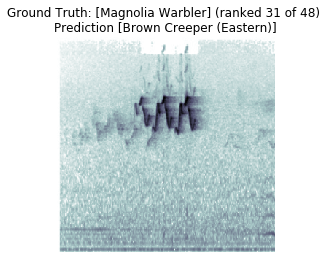

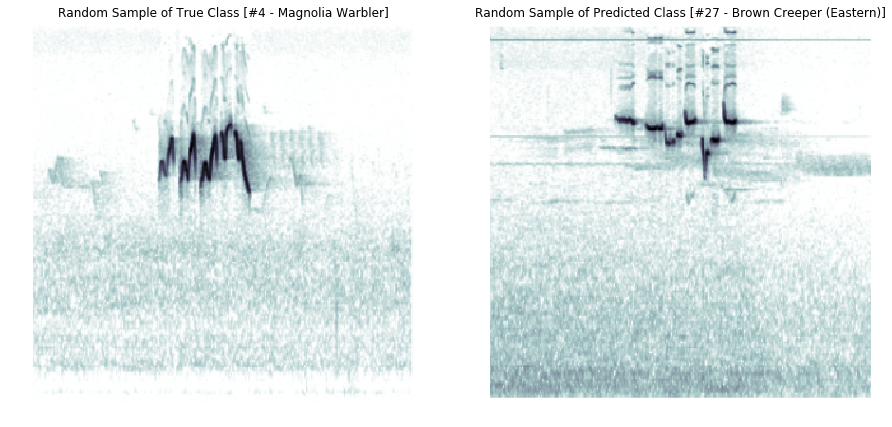

../snips/4/samples/11.wav


../snips/27/samples/2.wav


In [101]:
display_examples_with_samples(args)

In [ ]:
# Alternate display functions below:

In [44]:
def list_samples(directory, num_classes=48):
    """
    Get all the images and labels in directory/label/samples/* (.jpg or .wav)
    """
    labels = os.listdir(directory)
    # Sort the labels so that training and validation get them in the same order
    labels.sort()

    files_and_labels = []
    for label in labels:
        if int(label) > num_classes:
            continue
        for f in os.listdir(os.path.join(directory, label, 'samples')):
            if f.lower().endswith('.jpg'):
                name = os.path.splitext(f)[0]
                img_name = name + '.jpg'
                wav_name = name + '.wav'
                files_and_labels.append((os.path.join(directory, label, 'samples', img_name), 
                                         os.path.join(directory, label, 'samples', wav_name), 
                                         label))

    img_filenames, wav_filenames, labels = zip(*files_and_labels)
    img_filenames = list(img_filenames)
    wav_filenames = list(wav_filenames)
    labels = list(labels)
    unique_labels = list(set(labels))

    label_to_int = {}
    for i, label in enumerate(unique_labels):
        label_to_int[label] = i

    labels = [label_to_int[l] for l in labels]

    return img_filenames, wav_filenames, labels, files_and_labels


def random_sample(files_and_labels, label):
    label = str(label)
    num_samples = len(files_and_labels)
    count = 0
    
    while count < num_samples:
        img_sample, wav_sample, label_sample = files_and_labels[np.random.choice(len(files_and_labels))]
        if label_sample == label:
            return img_sample, wav_sample
        count += 1
        

def img_parse_function(filename):
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)          # (1)
    #image = tf.cast(image_decoded, tf.float32)
    image = tf.image.convert_image_dtype(image_decoded, dtype=tf.float32)
    image.set_shape([224, 341, 3])

    # Want a 3.5 second slice of 4.0 second spectrogram to be square (299x299) - set new_width accordingly
    new_height = tf.to_int32(299.0)
    new_width = tf.to_int32(319.0)     ## 341.0 
    crop_height = tf.to_int32(299.0)
    crop_width = tf.to_int32(299.0)

    image = tf.image.resize_images(image, [new_height, new_width])  # (2)

    max_offset_height = tf.reshape(new_height - crop_height + 1, [])
    max_offset_width = tf.reshape(new_width - crop_width + 1, [])
    offset_height = tf.constant(0, dtype=tf.int32)
    offset_width = tf.random_uniform([], maxval=max_offset_width, dtype=tf.int32)

    original_shape = tf.shape(image)
    cropped_shape = tf.stack([crop_height, crop_width, original_shape[2]])

    offsets = tf.to_int32(tf.stack([offset_height, offset_width, 0]))
    image = tf.slice(image, offsets, cropped_shape)
    image.set_shape([299, 299, 3])
    #image = tf.reshape(image, cropped_shape)

    image = tf.subtract(image, 0.5)
    image = tf.multiply(image, 2.0)
    
    image_raw = tf.expand_dims(image, 0)
    image_raw = tf.image.resize_images(image_raw, [crop_height, crop_width])
    image_raw = tf.squeeze(image_raw)

    return image, image_raw
        
        
         
def display_random_image(args, label):
    img_filenames, wav_filenames, labels, files_and_labels = list_samples(args['snip_dir'])
    num_classes = len(set(labels))
    assert num_classes == 48, "Incorrect label count:\n{}\n{}".format(num_classes, 48)
    labels_to_names = read_label_file(args['labels_path'])
    name = labels_to_names[label]

    try:
        img_sample, wav_sample = random_sample(files_and_labels, label)
    except TypeError:
        print("No sample with label %s" % str(label))
        return
    with tf.Graph().as_default():
        image, image_raw = img_parse_function(img_sample)
        with tf.Session() as sess:
            img = sess.run(image_raw)[:, :]
            img = ((img + 1.0)/2.0 * 255).round().astype(uint8)
            f, axarr = plt.subplots(1, 1, figsize=(7.5,15))
            axarr.imshow(img[:,:,0], cmap='bone')
            #axarr[1].imshow(img[:,:,0], cmap='bone')
            axarr.set_title('Ground Truth: [%s]' % (str(label)))
            axarr.axis('off')
            #axarr[1].set_title('Random Example of Predicted Class [%s]' % (str(label)))
            #axarr[1].axis('off')
            #plt.show()
            #plt.title('Label: [%s] \nName: [%s]' % (label, name))
            #plt.axis('off')
            plt.show()
            print(wav_sample)
            display(HTML('<a href="%s">WAV sample of class [%s]</a>' % (wav_sample, str(label))))

            
def display_two_samples(args, label1, label2):
    img_filenames, wav_filenames, labels, files_and_labels = list_samples(args['snip_dir'])
    num_classes = len(set(labels))
    assert num_classes == 48, "Incorrect label count:\n{}\n{}".format(num_classes, 48)
    labels_to_names = read_label_file(args['labels_path'])
    name1 = labels_to_names[label1]
    name2 = labels_to_names[label2]

    try:
        img_sample1, wav_sample1 = random_sample(files_and_labels, label1)
        img_sample2, wav_sample2 = random_sample(files_and_labels, label2)
    except TypeError:
        print("No sample with given label.")
        return
    
    with tf.Graph().as_default():
        image1, image_raw1 = img_parse_function(img_sample1)
        image2, image_raw2 = img_parse_function(img_sample2)
        with tf.Session() as sess:
            img1 = sess.run(image_raw1)[:, :]
            img1 = ((img1 + 1.0)/2.0 * 255).round().astype(uint8)
            img2 = sess.run(image_raw2)[:, :]
            img2 = ((img2 + 1.0)/2.0 * 255).round().astype(uint8)
            f, axarr = plt.subplots(1, 2, figsize=(15,15))
            axarr[0].imshow(img1[:,:,0], cmap='bone')
            axarr[1].imshow(img2[:,:,0], cmap='bone')
            axarr[0].set_title('Random Sample of True Class [#%s - %s]' % (str(label1), name1))
            axarr[0].axis('off')
            axarr[1].set_title('Random Sample of Predicted Class [#%s - %s]' % (str(label2), name2))
            axarr[1].axis('off')
            #plt.show()
            #plt.title('Label: [%s] \nName: [%s]' % (label, name))
            #plt.axis('off')
            plt.show()
            plt.savefig('foo.png', bbox_inches='tight')
            #f.savefig('foobar.png', bbox_inches='tight')
            print(wav_sample1)
            display(HTML('<a href="%s">WAV sample of class [#%s - %s]</a>' % (wav_sample1, 
                                                                              str(label1), name1)))
            print(wav_sample2)
            display(HTML('<a href="%s">WAV sample of class [#%s - %s]</a>' % (wav_sample2, 
                                                                              str(label2), name2)))
            


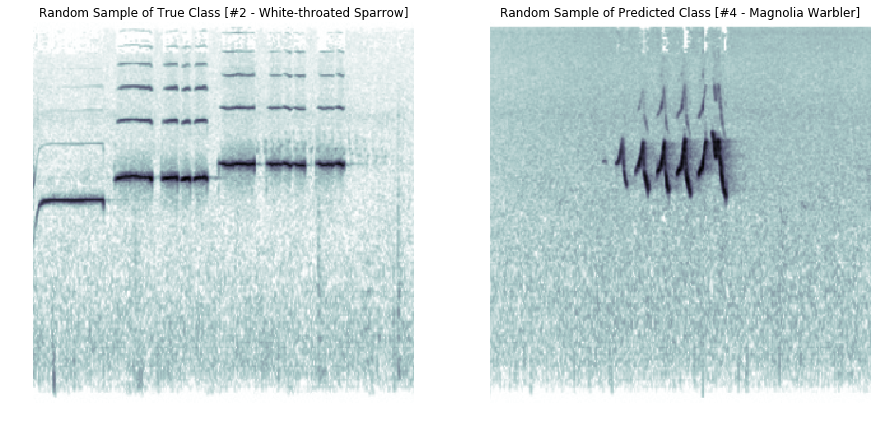

../snips/2/samples/15.wav


../snips/4/samples/2.wav


In [48]:
display_two_samples(args, 2, 4)

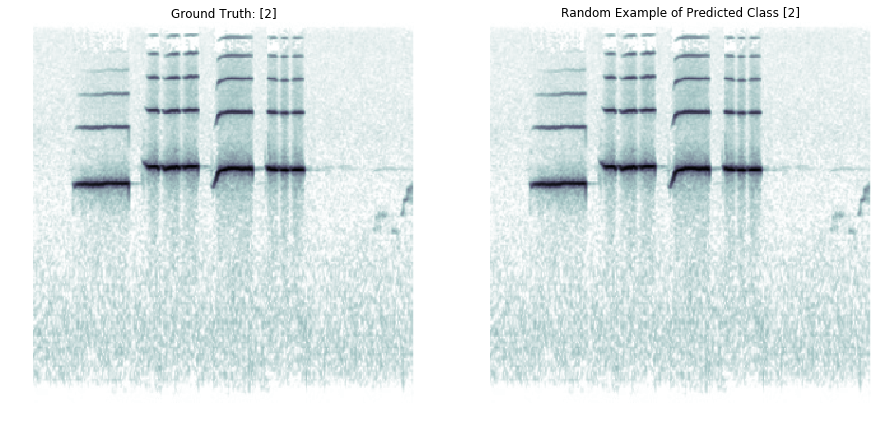

../snips/2/samples/18.wav


In [135]:
display_random_image(args, 2)